# LoL Churn Predictor [Part 2 - Data Cleaning and EDA]

**David Skarbrevik - 2018**

In part 1 we acquired League of Legends player gameplay data. Now we want to make sure our data is in good shape and perform some basic analysis to see if we can learn anything interesting about our data before we move on to modeling our churn prediction task.

<a id="toc"></a>

<br>
<hr style="background-color: black; padding: 1px;">
<br>

<h2>Table of Contents</h2>

<br>

<ol>
    <h3><li><a href="#section1">Planning</a></li></h3>
    <br>
    <h3><li><a href="#section2">Data cleaning</a></li></h3>
    <br>
    <h3><li><a href="#section3">Exploratory Data Analysis</a></li></h3>
</ol>

<br>
<hr style="background-color: black; padding: 1px;">
<br>

<a id='section1'></a>

## Step 1) Planning

### What kind of cleaning should I look into?

* check for missing data
* check for duplicate data
* make sure data is organized in an easily readable way

### What kind of basic questions would I like to ask of the data?

* Are the players under level 3 losing their first match more than those that get past level 3?
* Do the players under level 3 have a much lower KDA in their first match than those that get past level 3?
* How long is the average game for players at these low levels?

### Best visualizations to summarize this data?

* histogram of summoner level
* Bar charts of a few different stats, grouped by summoner level

### Assumptions / bias of this dataset [very important disclaimer]

While the Riot API theoretically gives access to ALL players of League of Legends, I made very specific restraints on what players would make it to my dataset when I collected my data. 

There were two main constraints:

**1) time constraint:** the player must have had their first match in 2018 and their most recent match (whether first or not) must not be more recent than 1 month before I collected their data.

**2) level constraint:** the player must not have a summoner level above 5.

The upper time constraint exists so that I can ensure that enough time has passed for a player to have "churned" by my definition (1 month of inactivity). And the lower time constraint exists to ensure that all players come from a similar time in the history of League of Legends. This keeps models more relevant to Riot's current situation while also holding many variables, that would confound analysis, a little more constant.

The level cap exists because of the method used to collect data. There is no easy way to get an even distribution of summoner levels, and since I am interested in new players, it is easiest to only collect data from low level players.

However, this means that any analysis of the data must always keep in mind that **this is a very specific sample of League of Legends players and is likely not representative of the population of all players.**

***

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section2'></a>

## Step 2) Data Cleaning

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

In [2]:
# this dataset has over 100 columns so pandas will truncate our results by default
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

**Import data**

In [17]:
df = pd.read_csv("./data/riot_master_df.csv", encoding="ISO-8859-1")

**Overview of Data**

In [18]:
df.head()

,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,first_match_duration,first_match_id,first_match_time,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,summoner_id,summoner_level,summoner_name,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,total_matches,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
0,16.0,12.0,0.0,5.1,0.0,0.0,0.0,4.80,0.0,0.0,0.0,4624.0,4624.0,4268.0,-205.3,0.0,0.0,0.0,388.2,0.0,0.0,0.0,0.0,0.0,False,False,True,False,False,False,0 days 00:14:00.000000000,2695060245,2018-01-16T05:50:54.986000+00:00,8012.0,496.3,0.0,0.0,0.0,2850.0,4.0,0.0,1054.0,3044.0,3067.0,1001.0,0.0,0.0,3340.0,1.0,13.0,MIDDLE,456.0,13.0,1.0,2018-01-17T06:05:14.227000+00:00,0.0,3005.0,2392.0,1005.0,0.0,0.0,0.0,0.0,4.0,0.0,8400.0,8200.0,48136.0,11330.0,7246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SOLO,0.0,92201075,5,TrEx18,18.0,51142.0,13723.0,8252.0,1128.0,63.0,0.0,0.0,274.0,1.0,7,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,True,371.20,0.0,0.0,0.0,583.9,0.0,0.0,0.0
1,4.0,11.0,0.0,3.5,0.0,0.0,0.0,1.72,0.0,0.0,0.0,1885.0,1885.0,5206.0,-200.0,0.0,0.0,0.0,478.0,0.0,0.0,0.0,2.0,3.0,False,False,False,False,False,False,0 days 00:16:41.000000000,2736710108,2018-03-10T06:24:33.477000+00:00,9014.0,318.3,0.0,0.0,0.0,8850.0,2.0,0.0,3142.0,3147.0,3111.0,1043.0,1036.0,1055.0,3340.0,2.0,13.0,NONE,0.0,9.0,2.0,2018-03-10T14:58:21.007000+00:00,654.0,968.0,888.0,3374.0,4.0,4.0,0.0,0.0,2.0,0.0,8100.0,8000.0,46817.0,12594.0,7109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,93650017,5,iMain N01,59.0,52490.0,13817.0,11503.0,3662.0,58.0,0.0,0.0,123.0,1.0,6,0.0,4704.0,334.0,1019.0,0.0,0.0,3.0,0.0,0.0,3.0,True,84.66,0.0,0.0,0.0,363.9,0.0,0.0,0.0
2,10.0,13.0,0.0,0.8,3.6,0.0,0.0,NaN,NaN,NaN,NaN,6838.0,5972.0,11147.0,NaN,NaN,NaN,NaN,564.3,862.1,0.0,0.0,2.0,0.0,False,False,True,False,False,False,0 days 00:22:54.000000000,2736716714,2018-03-10T06:56:11.750000+00:00,10869.0,353.0,412.7,0.0,0.0,6800.0,2.0,0.0,2003.0,1055.0,3133.0,3071.0,3076.0,3086.0,3340.0,3.0,10.0,JUNGLE,499.0,5.0,1.0,2018-03-21T08:32:17.048000+00:00,419.0,1229.0,288.0,2291.0,16.0,0.0,13.0,0.0,2.0,0.0,8100.0,8000.0,67383.0,10907.0,14573.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NONE,0.0,92729877,5,luexolu99,36.0,70890.0,11789.0,16942.0,879

In [19]:
df.shape

(1598, 116)

**Is there missing data?**

In [20]:
if df[df.isnull().any(axis=1)].empty:
    print("No missing values!")
else:
    print("Missing data from {} rows".format(df[df.isnull().any(axis=1)].shape[0]))

Missing data from 462 rows


**What columns are missing data?**

In [21]:
df.isnull().sum()

assists                                 1
champLevel                              1
combatPlayerScore                       1
creepsPerMinDeltas_0-10                 5
creepsPerMinDeltas_10-20                5
creepsPerMinDeltas_20-30                5
creepsPerMinDeltas_30-end               5
csDiffPerMinDeltas_0-10               446
csDiffPerMinDeltas_10-20              446
csDiffPerMinDeltas_20-30              446
csDiffPerMinDeltas_30-end             446
damageDealtToObjectives                 1
damageDealtToTurrets                    1
damageSelfMitigated                     1
damageTakenDiffPerMinDeltas_0-10      446
damageTakenDiffPerMinDeltas_10-20     446
damageTakenDiffPerMinDeltas_20-30     446
damageTakenDiffPerMinDeltas_30-end    446
damageTakenPerMinDeltas_0-10            5
damageTakenPerMinDeltas_10-20           5
damageTakenPerMinDeltas_20-30           5
damageTakenPerMinDeltas_30-end          5
deaths                                  1
doubleKills                       

**Dealing with the missing data**

We see that a lot of the columns are only missing 1 data point, this could be from a single player. Let's take a look:

In [22]:
df.loc[df['assists'].isnull()]

,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,first_match_duration,first_match_id,first_match_time,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,summoner_id,summoner_level,summoner_name,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,total_matches,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:28,2717262656,2018-02-12T21:53:43.622000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOP,NaN,NaN,NaN,2018-02-15T18:09:10.473000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DUO,NaN,92790619,3,ChiefShonah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Perhaps this player left his first game right as it started? Though if that is the reason, it's amazing there aren't at least a few more cases in our dataset like this. 

Let's see what the NaN column counts look like after we remove this player.

In [23]:
df = df.drop(df.index[982]) # drop one specific player

In [24]:
df.isnull().sum()

assists                                 0
champLevel                              0
combatPlayerScore                       0
creepsPerMinDeltas_0-10                 4
creepsPerMinDeltas_10-20                4
creepsPerMinDeltas_20-30                4
creepsPerMinDeltas_30-end               4
csDiffPerMinDeltas_0-10               445
csDiffPerMinDeltas_10-20              445
csDiffPerMinDeltas_20-30              445
csDiffPerMinDeltas_30-end             445
damageDealtToObjectives                 0
damageDealtToTurrets                    0
damageSelfMitigated                     0
damageTakenDiffPerMinDeltas_0-10      445
damageTakenDiffPerMinDeltas_10-20     445
damageTakenDiffPerMinDeltas_20-30     445
damageTakenDiffPerMinDeltas_30-end    445
damageTakenPerMinDeltas_0-10            4
damageTakenPerMinDeltas_10-20           4
damageTakenPerMinDeltas_20-30           4
damageTakenPerMinDeltas_30-end          4
deaths                                  0
doubleKills                       

OK, most of the columns don't have NaNs now, but a lot have exactly 4 or 445 missing values. These are all features with a time component, so it is likely that these games just didn't go long enough to produce values. However, because the 0-10min category also has 445 missing values it's possible that these are all players that dropped their first game shortly after joining the match. It should be appropriate to set those columns to 0.

But let's see what the data for these players looks like before we do that:

In [25]:
df.loc[df['xpDiffPerMinDeltas_0-10'].isnull()].head(n=10) # just choosing one of the time features, doesn't matter

,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,first_match_duration,first_match_id,first_match_time,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,summoner_id,summoner_level,summoner_name,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,total_matches,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
2,10.0,13.0,0.0,0.8,3.6,0.0,0.0,NaN,NaN,NaN,NaN,6838.0,5972.0,11147.0,NaN,NaN,NaN,NaN,564.3,862.1,0.0,0.0,2.0,0.0,False,False,True,False,False,False,0 days 00:22:54.000000000,2736716714,2018-03-10T06:56:11.750000+00:00,10869.0,353.0,412.7,0.0,0.0,6800.0,2.0,0.0,2003.0,1055.0,3133.0,3071.0,3076.0,3086.0,3340.0,3.0,10.0,JUNGLE,499.0,5.0,1.0,2018-03-21T08:32:17.048000+00:00,419.0,1229.0,288.0,2291.0,16.0,0.0,13.0,0.0,2.0,0.0,8100.0,8000.0,67383.0,10907.0,14573.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NONE,0.0,92729877,5,luexolu99,36.0,70890.0,11789.0,16942.0,8791.0,50.0,0.0,0.0,145.0,1.0,4,0.0,2277.0,593.0,77.0,2.0,0.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,331.8,464.2,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,0 days 00:28:54.000000000,2736217337,2018-03-09T13:05:59.377000+00:00,5089.0,100.0,164.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOP,0.0,0.0,0.0,2018-03-09T13:05:59.377000+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,8400.0,8200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,93839689,1,Md95359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
5,7.0,15.0,0.0,3.5,5.4,0.0,0.0,NaN,NaN,NaN,NaN,2130.0,2130.0,16903.0,NaN,NaN,NaN,NaN,321.5,740.3,0.0,0.0,5.0,3.0,False,False,True,False,False,False,0 days 00:26:05.000000000,2741305286,2018-03-16T20:15:31.237000+00:00,12784.0,386.4,518.8,0.0,0.0,12200.0,5.0,0.0,3072.0,3046.0,1029.0,3006.0,3031.0,0.0,3340.0,3.0,14.0,MIDDLE,665.0,7.0,2.0,2018-03-18T07:38:08.817000+00:00,780.0,6271.0,704.0,6075.0,12.0,8.0,4.0,0.0,5.0,0.0,8000.0,8200.0,106662.0,30303.0,11636.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO,0.0,93782084,5,Häsagi,40.0,112934.0,31008.0,18013.0,1967.0,109.0,0.0,0.0,110.0,1.0,6,0.0,0.0,0.0,301.0,1.0,0.0,0.0,0.0,0.0,0.0,True,Na

It appears that the these players actually did play their first match through, there was just an issue collecting the "timeline" data. 

**Possible solutions:**

**1) set all timeline NaNs to 0**

2) drop all timeline data from dataset

3) take summoner ids that have NaNs and re-mine their data to see if I can get it

**I'm going to try option 1**, but ultimately I'll want to take the time to do option 3 to reduce noise in my data and models.

In [26]:
time_columns = [i for i,x in enumerate(df.isnull().sum().tolist()) if x == 445 or x == 4] # columns with missing time data
time_cols = list(df.iloc[:, time_columns])
values = {col:0 for col in time_cols}
df = df.fillna(value = values)

In [27]:
df.isnull().sum()

assists                                0
champLevel                             0
combatPlayerScore                      0
creepsPerMinDeltas_0-10                0
creepsPerMinDeltas_10-20               0
creepsPerMinDeltas_20-30               0
creepsPerMinDeltas_30-end              0
csDiffPerMinDeltas_0-10                0
csDiffPerMinDeltas_10-20               0
csDiffPerMinDeltas_20-30               0
csDiffPerMinDeltas_30-end              0
damageDealtToObjectives                0
damageDealtToTurrets                   0
damageSelfMitigated                    0
damageTakenDiffPerMinDeltas_0-10       0
damageTakenDiffPerMinDeltas_10-20      0
damageTakenDiffPerMinDeltas_20-30      0
damageTakenDiffPerMinDeltas_30-end     0
damageTakenPerMinDeltas_0-10           0
damageTakenPerMinDeltas_10-20          0
damageTakenPerMinDeltas_20-30          0
damageTakenPerMinDeltas_30-end         0
deaths                                 0
doubleKills                            0
firstBloodAssist

OK now there are a few more features with NaNs. 

Let's look at "perkSubStyle":

In [28]:
df.loc[df['perkSubStyle'].isnull()].head(n=10)

,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,first_match_duration,first_match_id,first_match_time,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,summoner_id,summoner_level,summoner_name,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,total_matches,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
226,3.0,9.0,0.0,0.3,0.0,0.0,0.0,1.44,0.00,0.0,0.0,3619.0,3619.0,5428.0,-36.42,0.00,0.0,0.0,415.5,0.0,0.0,0.0,6.0,0.0,False,False,False,False,False,False,0 days 00:19:04.000000000,2736312050,2018-03-09T20:23:32.929000+00:00,6213.0,171.3,0.0,0.0,0.0,1250.0,5.0,0.0,1056.0,1026.0,0.0,0.0,0.0,0.0,3341.0,0.0,1.0,NONE,0.0,0.0,1.0,2018-03-17T17:44:56.142000+00:00,251.0,9006.0,1256.0,2489.0,0.0,0.0,0.0,0.0,5.0,0.0,8200.0,NaN,7273.0,854.0,5197.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,93689587,5,spicyemperor908,0.0,23342.0,2782.0,7687.0,1359.0,20.0,0.0,0.0,15.0,3.0,9,0.0,7062.0,672.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,True,83.02,0.0,0.0,0.0,153.9,0.0,0.0,0.0
269,4.0,14.0,0.0,3.4,2.2,0.0,0.0,0.00,0.00,0.0,0.0,3245.0,3245.0,11722.0,0.00,0.00,0.0,0.0,139.1,706.7,0.0,0.0,0.0,0.0,False,False,False,False,False,True,0 days 00:29:06.000000000,2736833894,2018-03-10T14:20:37.391000+00:00,12213.0,336.0,364.7,0.0,0.0,5300.0,2.0,0.0,1054.0,1054.0,3044.0,3111.0,3067.0,3044.0,3340.0,1.0,16.0,MIDDLE,0.0,16.0,1.0,2018-03-11T03:25:16.314000+00:00,0.0,7765.0,4105.0,5165.0,2.0,2.0,0.0,0.0,2.0,0.0,8400.0,NaN,55694.0,14893.0,9645.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_CARRY,0.0,93879843,5,GregJuan,20.0,67435.0,18999.0,14810.0,1486.0,74.0,0.0,0.0,157.0,1.0,5,0.0,3975.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,True,0.00,0.0,0.0,0.0,516.9,320.8,0.0,0.0
272,15.0,7.0,0.0,0.4,0.0,0.0,0.0,0.94,0.00,0.0,0.0,862.0,862.0,2395.0,-385.64,0.00,0.0,0.0,338.9,0.0,0.0,0.0,4.0,0.0,False,False,True,False,True,False,0 days 00:12:28.000000000,2743505380,2018-03-19T05:31:31.571000+00:00,4463.0,299.7,0.0,0.0,0.0,3150.0,2.0,0.0,3111.0,3044.0,3067.0,0.0,0.0,0.0,3340.0,1.0,3.0,NONE,0.0,2.0,1.0,2018-03-19T06:07:50.345000+00:00,242.0,611.0,443.0,249.0,0.0,0.0,0.0,0.0,2.0,0.0,8400.0,NaN,9466.0,2954.0,4761.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,27808934,4,DeathOni,5.0,12818.0,3397.0,5011.0,65.0,7.0,0.0,0.0,65.0

What are some normal values for this feature?

In [29]:
Counter(df['perkSubStyle'])

Counter({8000.0: 234,
         8100.0: 504,
         8200.0: 843,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1})

I'm not sure what this feature describes, but because not all players have just one value, this may be a useful feature. Because only a small percent of players are missing this value, I am simply going to remove those players from the dataset.

In [30]:
perksub_nan = list(df.loc[df['perkSubStyle'].isnull()].index.values)
df = df.drop(perksub_nan)

Now let's look at the last 4 features with NaN values:

In [31]:
features_with_nan = ["firstInhibitorAssist", "firstInhibitorKill", "firstTowerAssist", "firstTowerKill"]

for feature in features_with_nan:
    print("Feature name: {}".format(feature))
    print(Counter(df[feature]))
    print("\n")

Feature name: firstInhibitorAssist
Counter({False: 1274, True: 302, nan: 5})


Feature name: firstInhibitorKill
Counter({False: 1388, True: 188, nan: 5})


Feature name: firstTowerAssist
Counter({False: 1389, True: 191, nan: 1})


Feature name: firstTowerKill
Counter({False: 1379, True: 201, nan: 1})




As with the 'perkSubStyle' feature there are only a few players with NaN values in the features above. I don't want to randomly assign True or False to these players so I will simply drop them.

In [32]:
nan_index = sum([list(df.loc[df[feature].isnull()].index.values) for feature in features_with_nan], [])
df = df.drop(nan_index)

Let's make sure we don't have any more NaN values:

In [33]:
if df[df.isnull().any(axis=1)].empty:
    print("No missing values!")
else:
    print("Missing data from {} rows".format(df[df.isnull().any(axis=1)].shape[0]))

No missing values!


**Dealing with duplicate rows**

In [34]:
print("Number of duplicate rows in dataset: {}".format(Counter(df.duplicated())[True]))

Number of duplicate rows in dataset: 81


In [35]:
old_rows = df.shape[0]

df = df.drop_duplicates()

new_rows = df.shape[0]

diff = old_rows - new_rows

print("Number of rows removed: {}".format(diff))

Number of rows removed: 81


Good, the number of rows we removed equals the number of duplicate rows so that's a good sign! Ideally there would have been 0 duplicate rows, because I have a check in my data collection functions to try and avoid this. But for now we'll just remove our duplicates.

Now let's rearrange some of the features that tell us about a player but won't be useful in training our model. This will make this a more interesting "at first glance" dataset.

In [36]:
columns = list(df)
front_features = ['summoner_id', 'summoner_name', 'summoner_level', 'total_matches',
                  'first_match_time', 'first_match_duration', 'first_match_id']

In [37]:
len(columns)

116

In [38]:
cols_reordered = [item for item in columns if item not in front_features]
cols_reordered = front_features + cols_reordered

In [39]:
df = df[cols_reordered]

In [40]:
df.head()

,summoner_id,summoner_name,summoner_level,total_matches,first_match_time,first_match_duration,first_match_id,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
0,92201075,TrEx18,5,7,2018-01-16T05:50:54.986000+00:00,0 days 00:14:00.000000000,2695060245,16.0,12.0,0.0,5.1,0.0,0.0,0.0,4.80,0.0,0.0,0.0,4624.0,4624.0,4268.0,-205.3,0.0,0.0,0.0,388.2,0.0,0.0,0.0,0.0,0.0,False,False,True,False,False,False,8012.0,496.3,0.0,0.0,0.0,2850.0,4.0,0.0,1054.0,3044.0,3067.0,1001.0,0.0,0.0,3340.0,1.0,13.0,MIDDLE,456.0,13.0,1.0,2018-01-17T06:05:14.227000+00:00,0.0,3005.0,2392.0,1005.0,0.0,0.0,0.0,0.0,4.0,0.0,8400.0,8200.0,48136.0,11330.0,7246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SOLO,0.0,18.0,51142.0,13723.0,8252.0,1128.0,63.0,0.0,0.0,274.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,True,371.20,0.0,0.0,0.0,583.9,0.0,0.0,0.0
1,93650017,iMain N01,5,6,2018-03-10T06:24:33.477000+00:00,0 days 00:16:41.000000000,2736710108,4.0,11.0,0.0,3.5,0.0,0.0,0.0,1.72,0.0,0.0,0.0,1885.0,1885.0,5206.0,-200.0,0.0,0.0,0.0,478.0,0.0,0.0,0.0,2.0,3.0,False,False,False,False,False,False,9014.0,318.3,0.0,0.0,0.0,8850.0,2.0,0.0,3142.0,3147.0,3111.0,1043.0,1036.0,1055.0,3340.0,2.0,13.0,NONE,0.0,9.0,2.0,2018-03-10T14:58:21.007000+00:00,654.0,968.0,888.0,3374.0,4.0,4.0,0.0,0.0,2.0,0.0,8100.0,8000.0,46817.0,12594.0,7109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,59.0,52490.0,13817.0,11503.0,3662.0,58.0,0.0,0.0,123.0,1.0,0.0,4704.0,334.0,1019.0,0.0,0.0,3.0,0.0,0.0,3.0,True,84.66,0.0,0.0,0.0,363.9,0.0,0.0,0.0
2,92729877,luexolu99,5,4,2018-03-10T06:56:11.750000+00:00,0 days 00:22:54.000000000,2736716714,10.0,13.0,0.0,0.8,3.6,0.0,0.0,0.00,0.0,0.0,0.0,6838.0,5972.0,11147.0,0.0,0.0,0.0,0.0,564.3,862.1,0.0,0.0,2.0,0.0,False,False,True,False,False,False,10869.0,353.0,412.7,0.0,0.0,6800.0,2.0,0.0,2003.0,1055.0,3133.0,3071.0,3076.0,3086.0,3340.0,3.0,10.0,JUNGLE,499.0,5.0,1.0,2018-03-21T08:32:17.048000+00:00,419.0,1229.0,288.0,2291.0,16.0,0.0,13.0,0.0,2.0,0.0,8100.0,8000.0,67383.0,10907.0,14573.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NONE,0.0,36.0,70890.0,11789.0,16942.0,

Lastly, let's save this dataset as a "cleaned_riot_data.csv" file for future use.

In [41]:
df.to_csv("./data/cleaned_riot_data.csv", index=False)

***

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section3'></a>

## Step 3) Exploratory Data Analysis

In [92]:
from scipy import stats, integrate
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import arrow
import datetime


%matplotlib inline

In [4]:
df = pd.read_csv("./data/cleaned_riot_data.csv", encoding="ISO-8859-1")

**Let's better understand the summoner levels of players in our dataset since this is the key feature that we will likely want to predict on later.**

In [5]:
summoner_levels = df.summoner_level
np.mean(summoner_levels)

3.471571906354515

Average summoner level = 3.471571906354515


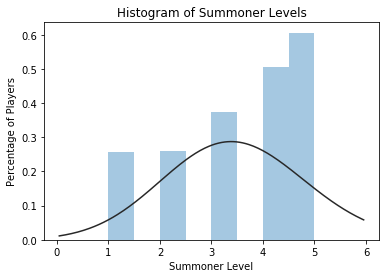

In [15]:
hist = sns.distplot(summoner_levels, kde=False, fit=stats.gamma)
hist.set(title="Histogram of Summoner Levels", xlabel="Summoner Level", ylabel="Percentage of Players")
print("Average summoner level = {}".format(np.mean(df.summoner_level)))

Of course we see that players are only levels 1-5 as we required during the data collection phase. Most are level 4 or 5 as an artifact of the collection process but a fair amount are still levels 1-3 so there should be enough examples of these low level players to train a decent model.

**Now let's see the timeline range for the match history of players in the dataset.**

In [16]:
list(df)

['summoner_id',
 'summoner_name',
 'summoner_level',
 'total_matches',
 'first_match_time',
 'first_match_duration',
 'first_match_id',
 'assists',
 'champLevel',
 'combatPlayerScore',
 'creepsPerMinDeltas_0-10',
 'creepsPerMinDeltas_10-20',
 'creepsPerMinDeltas_20-30',
 'creepsPerMinDeltas_30-end',
 'csDiffPerMinDeltas_0-10',
 'csDiffPerMinDeltas_10-20',
 'csDiffPerMinDeltas_20-30',
 'csDiffPerMinDeltas_30-end',
 'damageDealtToObjectives',
 'damageDealtToTurrets',
 'damageSelfMitigated',
 'damageTakenDiffPerMinDeltas_0-10',
 'damageTakenDiffPerMinDeltas_10-20',
 'damageTakenDiffPerMinDeltas_20-30',
 'damageTakenDiffPerMinDeltas_30-end',
 'damageTakenPerMinDeltas_0-10',
 'damageTakenPerMinDeltas_10-20',
 'damageTakenPerMinDeltas_20-30',
 'damageTakenPerMinDeltas_30-end',
 'deaths',
 'doubleKills',
 'firstBloodAssist',
 'firstBloodKill',
 'firstInhibitorAssist',
 'firstInhibitorKill',
 'firstTowerAssist',
 'firstTowerKill',
 'goldEarned',
 'goldPerMinDeltas_0-10',
 'goldPerMinDeltas_10-

In [38]:
df_match_creation['time'] = df_match_creation['time'].apply(arrow.get)

In [39]:
df_match_creation.head()

,time,count
0,2018-01-01T00:00:00+00:00,68
1,2018-01-01T00:00:00+00:00,191
2,2018-01-01T00:00:00+00:00,101
3,2018-01-01T00:00:00+00:00,56
4,2018-01-01T00:00:00+00:00,115


In [46]:
df['first_match_time'].head()

0    2018-01-16T05:50:54.986000+00:00
1    2018-03-10T06:24:33.477000+00:00
2    2018-03-10T06:56:11.750000+00:00
3    2018-03-09T13:05:59.377000+00:00
4    2018-03-09T11:42:58.309000+00:00
Name: first_match_time, dtype: object

In [55]:
test = df_match_creation = pd.DataFrame.from_dict(Counter(df.first_match_time), orient='index').reset_index()
test = test.rename(columns={'index':'time', 0:'count'})

In [67]:
sns.barplot(x=str(test.time), y=test.count)

ValueError: Could not interpret input '0      2018-01-16 05:50:54.986
1      2018-03-10 06:24:33.477
2      2018-03-10 06:56:11.750
3      2018-03-09 13:05:59.377
4      2018-03-09 11:42:58.309
5      2018-03-16 20:15:31.237
6      2018-03-11 19:44:54.730
7      2018-03-11 00:03:26.958
8      2018-03-11 06:03:19.450
9      2018-03-18 01:23:42.856
10     2018-03-17 05:57:56.831
11     2018-03-16 00:54:30.725
12     2018-03-11 03:19:41.944
13     2018-03-10 08:50:24.657
14     2018-03-10 18:57:03.444
15     2018-03-10 15:20:00.572
16     2018-03-10 10:18:55.191
17     2018-03-08 02:00:31.856
18     2018-03-02 16:04:30.777
19     2018-01-17 04:23:06.553
20     2018-01-15 02:31:41.928
21     2018-01-15 02:55:40.470
22     2018-01-16 05:24:21.075
23     2018-01-15 20:34:33.886
24     2018-01-18 09:45:56.869
25     2018-03-10 12:20:04.519
26     2018-03-10 01:52:40.047
27     2018-03-09 19:01:15.186
28     2018-03-10 02:37:43.874
29     2018-03-10 06:04:01.827
30     2018-03-17 04:20:36.756
31     2018-03-10 06:33:33.457
32     2018-02-18 04:09:21.928
33     2018-03-17 00:53:32.572
34     2018-03-07 08:27:11.011
35     2018-03-10 04:12:00.404
36     2018-03-11 23:25:16.590
37     2018-03-09 14:18:48.732
38     2018-03-04 06:23:22.719
39     2018-03-10 22:10:36.687
40     2018-03-03 06:27:54.663
41     2018-03-11 01:15:17.459
42     2018-03-18 15:40:22.545
43     2018-03-17 21:44:06.689
44     2018-03-17 16:17:41.678
45     2018-03-16 01:15:09.635
46     2018-03-08 04:58:56.259
47     2018-03-10 06:08:46.568
48     2018-03-10 14:13:11.743
49     2018-03-08 02:22:56.219
50     2018-01-17 04:08:42.187
51     2018-01-16 06:31:10.031
52     2018-01-16 06:12:06.223
53     2018-01-16 05:20:57.448
54     2018-01-15 02:36:30.394
55     2018-01-16 19:12:37.436
56     2018-01-16 05:29:06.066
57     2018-03-11 03:47:15.219
58     2018-03-19 03:17:24.753
59     2018-03-10 12:10:59.639
60     2018-03-10 06:12:29.473
61     2018-03-10 12:42:34.076
62     2018-03-09 20:23:32.929
63     2018-03-09 11:36:16.979
64     2018-03-10 12:01:03.040
65     2018-03-10 09:39:46.271
66     2018-03-10 02:57:10.783
67     2018-03-10 04:56:09.082
68     2018-03-21 07:37:59.143
69     2018-02-05 05:33:46.751
70     2018-03-17 03:46:16.780
71     2018-03-16 17:54:50.573
72     2018-02-18 01:40:56.656
73     2018-02-17 09:18:27.376
74     2018-03-17 00:41:48.414
75     2018-03-17 01:18:28.002
76     2018-03-07 10:06:14.784
77     2018-03-07 10:23:51.164
78     2018-03-07 08:09:14.928
79     2018-03-10 04:55:35.997
80     2018-03-10 03:44:09.656
81     2018-03-05 02:47:45.416
82     2018-02-28 16:20:24.463
83     2018-03-04 04:29:30.050
84     2018-03-07 04:34:44.279
85     2018-03-03 19:36:38.831
86     2018-03-10 02:43:00.668
87     2018-03-10 02:15:28.519
88     2018-03-11 07:35:11.275
89     2018-03-11 07:26:17.192
90     2018-03-07 01:15:29.889
91     2018-03-19 05:14:30.516
92     2018-03-18 16:06:01.021
93     2018-03-19 00:20:18.667
94     2018-03-18 23:35:12.054
95     2018-03-17 20:03:13.088
96     2018-03-17 20:57:36.807
97     2018-03-08 04:16:30.469
98     2018-03-10 16:33:27.864
99     2018-03-10 15:16:29.538
                 ...          
1169   2018-03-14 04:24:35.209
1170   2018-02-24 03:08:30.046
1171   2018-03-02 00:39:55.053
1172   2018-03-04 00:57:15.750
1173   2018-03-12 04:47:52.579
1174   2018-03-05 02:50:31.861
1175   2018-03-12 04:04:14.590
1176   2018-03-12 00:35:50.407
1177   2018-03-12 00:14:37.976
1178   2018-03-04 02:13:09.305
1179   2018-03-05 01:34:15.346
1180   2018-03-11 23:57:23.200
1181   2018-03-11 22:41:19.072
1182   2018-03-11 22:04:16.547
1183   2018-03-11 23:09:15.053
1184   2018-02-12 01:19:36.614
1185   2018-03-11 22:23:27.680
1186   2018-03-11 22:13:24.132
1187   2018-03-18 00:22:52.503
1188   2018-03-15 09:22:00.752
1189   2018-03-12 12:30:27.922
1190   2018-03-12 13:13:41.562
1191   2018-03-12 10:27:23.408
1192   2018-03-12 09:54:01.782
1193   2018-03-09 06:04:02.952
1194   2018-01-13 15:38:45.485
1195   2018-03-12 16:43:08.071
1196   2018-03-12 16:05:24.526
1197   2018-03-12 18:11:33.159
1198   2018-03-07 03:59:52.667
1199   2018-02-27 04:05:39.899
1200   2018-03-09 01:36:52.170
1201   2018-03-06 01:16:32.266
1202   2018-03-12 23:52:25.150
1203   2018-03-03 13:56:48.079
1204   2018-03-07 22:58:20.443
1205   2018-03-14 06:27:17.348
1206   2018-03-14 05:33:14.888
1207   2018-03-14 06:17:16.275
1208   2018-03-14 05:23:45.960
1209   2018-03-13 04:32:09.328
1210   2018-03-14 03:15:20.499
1211   2018-03-13 23:48:08.727
1212   2018-03-14 00:03:21.090
1213   2018-03-14 05:31:52.908
1214   2018-03-14 04:27:14.117
1215   2018-03-08 04:57:08.573
1216   2018-03-02 10:06:30.734
1217   2018-03-03 16:21:15.284
1218   2018-03-07 12:05:12.651
1219   2018-03-07 12:25:42.623
1220   2018-02-28 11:12:24.023
1221   2018-03-06 10:04:37.766
1222   2018-03-05 17:48:43.945
1223   2018-01-17 03:55:32.386
1224   2018-03-03 00:15:26.207
1225   2018-03-03 06:26:19.871
1226   2018-03-02 22:07:34.280
1227   2018-03-14 19:39:10.107
1228   2018-03-15 17:31:10.960
1229   2018-03-16 19:17:46.872
1230   2018-03-16 01:55:14.725
1231   2018-03-16 19:04:25.871
1232   2018-03-04 21:09:31.068
1233   2018-03-04 20:15:22.440
1234   2018-03-06 20:04:31.771
1235   2018-02-05 16:27:54.807
1236   2018-03-12 15:08:19.549
1237   2018-03-19 22:49:59.146
1238   2018-03-18 15:37:56.775
1239   2018-03-18 15:30:59.172
1240   2018-03-18 15:12:18.001
1241   2018-03-06 19:48:31.866
1242   2018-03-06 08:25:09.416
1243   2018-03-05 13:42:50.302
1244   2018-01-15 21:48:22.149
1245   2018-03-05 20:25:15.346
1246   2018-03-04 12:15:36.644
1247   2018-02-19 03:33:12.487
1248   2018-03-06 16:57:44.659
1249   2018-03-07 17:07:00.874
1250   2018-03-06 00:51:16.197
1251   2018-03-05 19:15:43.496
1252   2018-02-21 13:58:15.629
1253   2018-03-04 19:00:01.344
1254   2018-03-04 04:28:27.696
1255   2018-02-28 04:51:21.511
1256   2018-02-27 22:23:34.958
1257   2018-02-27 23:27:45.382
1258   2018-03-03 20:30:13.498
1259   2018-03-12 05:51:12.974
1260   2018-03-13 02:47:58.871
1261   2018-03-13 02:05:24.489
1262   2018-03-11 19:27:33.540
1263   2018-03-09 00:39:42.558
1264   2018-03-13 04:07:25.817
1265   2018-02-16 02:45:18.402
1266   2018-02-25 20:03:33.124
1267   2018-02-25 00:50:24.812
1268   2018-02-27 01:02:36.345
Name: time, Length: 1269, dtype: datetime64[ns]'

In [59]:
test.time = test.time.astype("datetime64")

C:\Users\skarb\Anaconda3\lib\site-packages\pandas\core\internals.py:3224: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)


In [64]:
test_plot = sns.barplot(x=test.time.dt.date, y=test.count)

TypeError: float() argument must be a string or a number, not 'method'

In [88]:
years = [arrow.get(x).format('MM-DD-YYYY') for x in df['first_match_time']]
df_match_creation = pd.DataFrame.from_dict(Counter(years), orient='index').reset_index()
df_match_creation = df_match_creation.rename(columns={'index':'time', 0:'count'})
df_match_creation = df_match_creation.sort_values(by="time")

[Text(0,0.5,'Number of Players'),
 Text(0.5,0,"Date of Player's First Match"),
 Text(0.5,1,"Time of Player's First Match")]

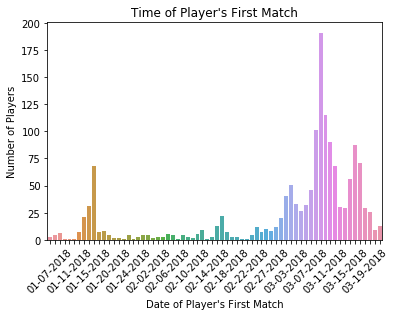

In [96]:
ax = sns.barplot(x=df_match_creation['time'], y=df_match_creation['count'])
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % 4 != 0]
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set(title="Time of Player's First Match", xlabel="Date of Player's First Match", ylabel="Number of Players")


In [97]:
# save high-res for website
ax = ax.get_figure()
ax.savefig("./docs/first_matches_high_res.png", dpi=1000)

***

<div align="right">
    <a href="#toc">back to top</a>
</div>

## End of Part 2

### In the <a href="https://nbviewer.jupyter.org/github/dskarbrevik/League-of-Legends-Churn-Prediction/blob/master/LoL%20Churn%20Predictor%20%5BPart%203%20-%20Data%20Modeling%5D.ipynb">next notebook</a>, we'll get our data ready for modeling and test out a few models to finally see if we can make our "churn" predictions as we set out to do from the start!